# 🚀 🚧 Séance 3 - Cours / Travail Pratique

Apprenez à utiliser Python et PyTorch pour la classification d'images en entraînant un modèle sur le jeu de données MNIST, avec pour objectif d'appliquer ces méthodologies aux images satellites pour votre projet.

## 📌 Importer les bibliothèques et les outils

In [2]:
#Import necessary libraries
import torch
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split
from torchvision.models import resnet18
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score
import seaborn as sns
import itertools
from tqdm import tqdm

#If you do not want to see the library warnings on Python Notebooks
import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning)
warnings.filterwarnings('ignore', category=UserWarning)

## 📌 Sélectionner les dispositifs de calcul pour le Machine Learning

### a) CPU (Central Processing Unit)

<B>Disponibilité :</B> Universelle (Windows, Mac, Linux)

<B>Description :</B> Le processeur polyvalent capable de gérer tous types de tâches. Bien qu'il soit le plus lent parmi les processeurs spécialisés pour les tâches parallèles, comme celles courantes en apprentissage automatique, il est universellement disponible et ne nécessite aucun matériel spécial.

### b) CUDA (Compute Unified Device Architecture)

<B>Disponibilité :</B> GPU NVIDIA sur Windows et Linux.

<B>Description :</B> Une plateforme de calcul parallèle et une API de NVIDIA, permettant un accès direct à l'ensemble d'instructions virtuelles du GPU et à ses éléments de calcul parallèle. Elle est idéale pour le calcul haute performance dans des domaines comme l'apprentissage profond où le traitement parallèle peut accélérer considérablement les calculs.

### c) Metal (Apple’s Graphics API)

<B>Disponibilité :</B> Uniquement sur Mac.

<B>Description :</B> Développé par Apple pour optimiser les performances des jeux et des applications professionnelles sous iOS et macOS, Metal peut également être utilisé pour des tâches de calcul en apprentissage automatique. Il permet à PyTorch et à d'autres frameworks d'utiliser le GPU des Macs pour une vitesse de traitement accrue.

In [3]:
#Function to choose the device
def get_device():
    if torch.cuda.is_available():
        #Use CUDA device if available
        return torch.device("cuda"), "CUDA"
    elif torch.backends.mps.is_available():
        #Use Apple Metal if available on Mac
        return torch.device("cuda"), "cuda2"
    else:
        # default to CPU
        return torch.device("cuda"), "cuda3"

#Setting the device
device, device_name = get_device()
print(f"Using device: {device_name}")

Using device: CUDA


## 📌 Analyse Exploratoire des Données (EDA)


------ CLASSES ------
Class indices: {'0 - zero': 0, '1 - one': 1, '2 - two': 2, '3 - three': 3, '4 - four': 4, '5 - five': 5, '6 - six': 6, '7 - seven': 7, '8 - eight': 8, '9 - nine': 9}
------ IMAGES ------
Total images: 60000
Size of image: torch.Size([32, 1, 28, 28])


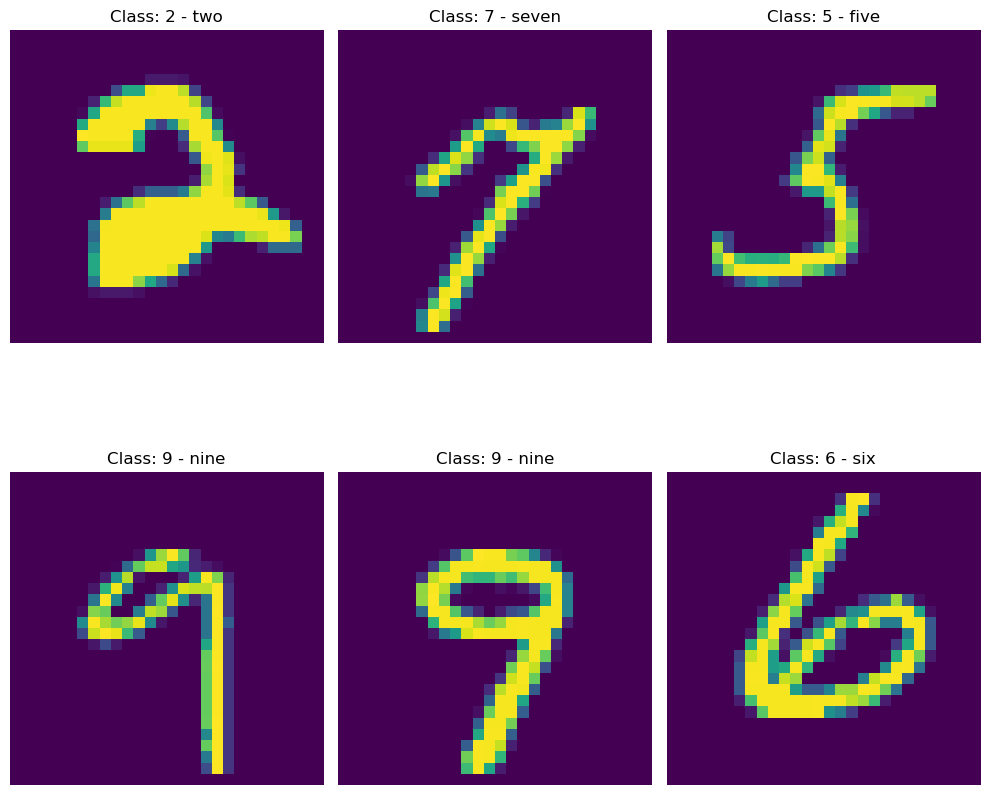

In [4]:
#Define transformations
transform = transforms.Compose([
    transforms.ToTensor(),  #Converts the PIL Image to a tensor.
    transforms.Normalize((0.1307,), (0.3081,))  #Normalizes the tensor with mean and standard deviation.
])

#Load images from structured directory with automatic labeling based on folder names and apply transformations
dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)

#Display class indices and names
print("------ CLASSES ------")
print("Class indices:", dataset.class_to_idx)
classes = dataset.classes

#DataLoader manages data shuffling and batching automatically
batch_size = 32  #Defines how many samples are processed before the model updates
data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=4)

images, _ = next(iter(data_loader))

#Display the number of images
print("------ IMAGES ------")
print(f'Total images: {len(dataset)}')
print(f'Size of image: {images.shape}')

def show_six_images(data_loader, dataset):
    # Fetch the first batch of images and labels
    images, classes = next(iter(data_loader))

    #Define the number of images to display
    num_images = 6

    #Create a figure with subplots in a 2x3 configuration
    fig, axes = plt.subplots(2, 3, figsize=(10, 10))  #2 rows, 3 columns
    axes = axes.flatten()  #Flatten the 2D array of axes into 1D for easier iteration

    #Loop through the first six images (or less if the batch is smaller)
    for idx, ax in enumerate(axes):
        if idx < num_images:
            #Convert the tensor image to a NumPy array for display
            img = images[idx].numpy()  #Change from (C, H, W) to (H, W, C)

            # Display the image
            ax.imshow(img.squeeze())
            ax.set_title(f'Class: {dataset.classes[classes[idx]]}')  #Set the title to the class label
            ax.axis('off')  #Hide the axes

        else:
            ax.axis('off')  # ide unused subplots

    plt.tight_layout()
    plt.show()

show_six_images(data_loader,dataset)

## 📌 Prétraitement des données pour l'entraînement

### a) Définir des transformations séparées pour l'entraînement et les tests

<B>Transformations d'entraînement :</B> Le jeu de données d'entraînement utilise une série de transformations pour introduire de la variabilité dans le jeu de données. Celles-ci incluent le retournement, la rotation et le recadrage. De telles transformations sont cruciales pour former des modèles robustes qui généralisent bien à travers des entrées de données variées.

<B>Transformations de test :</B> Pour le jeu de données de test, les transformations sont minimisées — redimensionnement, conversion en tensor et normalisation — dans le but de préserver les caractéristiques originales des données pour évaluer précisément la performance du modèle.

In [5]:
#Transformations for the training data (with augmentation)
train_transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),  #Convert 1 channel grayscale (MNIST) to 3 channel for model ResNet-18 input
    transforms.RandomRotation(10, fill=(0,0,0)),  #Rotate by up to 10 degrees filling with 0
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),  #Random translation
    transforms.ToTensor(),
    transforms.Normalize((0.1307, 0.1307, 0.1307), (0.3081, 0.3081, 0.3081))
])

#Transformations for the testing data (without augmentation)
test_transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),  #Convert 1 channel grayscale (MNIST) to 3 channel for model ResNet-18 input
    transforms.ToTensor(),
    transforms.Normalize((0.1307, 0.1307, 0.1307), (0.3081, 0.3081, 0.3081))
])

### b) Chargement du jeu de données et application de la division

<B>Chargement du jeu de données :</B> Le jeu de données MNIST est chargé en utilisant `datasets.MNIST` sans aucune transformation initiale. Cela permet une application dynamique des transformations plus tard, en fonction de l'utilisation des données pour l'entraînement ou les tests.

<B>Division du jeu de données :</B> Le jeu de données est divisé en ensembles d'entraînement et de test en utilisant `random_split`, assurant une division aléatoire qui aide à réduire les biais pendant l'entraînement et les tests. (ce n'est pas le cas ici puisque nous avons accès aux jeux de données déjà divisés)

In [6]:
#Loading dataset
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=train_transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=test_transform)

#### FOR IMAGES ####
#Load the dataset without any transformations
#full_dataset = torchvision.datasets.ImageFolder(root=data_path)

#Split the dataset into train and test sets
#train_size = int(0.8 * len(full_dataset))  # 80% of the dataset for training
#test_size = len(full_dataset) - train_size  # Remaining 20% for testing
#train_dataset, test_dataset = random_split(full_dataset, [train_size, test_size])

### c) Application dynamique des transformations pour les images

<B>Application dynamique des transformations :</B> Une fonction `apply_transforms` est utilisée pour appliquer les transformations respectives à chaque sous-ensemble du jeu de données. Ceci est réalisé en itérant sur les indices de chaque division (entraînement ou test) et en appliquant les transformations prédéfinies. Cette approche manuelle garantit que l'augmentation des données est appliquée uniquement aux données d'entraînement.

<B>Création du chargeur de données :</B> Des instances de `DataLoader` sont créées pour les données d'entraînement et de test transformées. Ces chargeurs gèrent la mise en lots, le mélange (pour les données d'entraînement) et le multithreading pour rationaliser le processus d'alimentation des données dans le modèle pendant l'entraînement et l'évaluation.

In [7]:
#Create DataLoader instances
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=4)

#### FOR IMAGES ####
#Function to apply transformations dynamically
#def apply_transforms(dataset, transform):
#    transformed_data = [(transform(image), label) for image, label in [dataset.dataset[idx] for idx in dataset.indices]]
#    return transformed_data

#Transform the datasets
#train_dataset = apply_transforms(train_dataset, train_transform)
#test_dataset = apply_transforms(test_dataset, test_transform)

## 📌 Entraînement du modèle avec un CNN pré-entraîné

### a) Chargement d'un modèle ResNet-18 pré-entraîné

Charge un modèle ResNet-18 pré-entraîné, modifie la dernière couche pour s'adapter à un nombre différent de classes (10 dans cet exemple) et s'assure que le modèle est sur le bon périphérique (GPU ou CPU).

In [8]:
#Load a pretrained ResNet-18 model
model = resnet18(pretrained=True)
num_features = model.fc.in_features
print(f'Numbers of features in last layer of the pretrained model :{num_features}')
model.fc = nn.Linear(num_features, 10)  #Adjust for 10 output classes
model = model.to(device)  #Move model to the appropriate device

Numbers of features in last layer of the pretrained model :512


### b) Configuration de la fonction de perte et de l'optimiseur

La perte de Cross-Entropy est couramment utilisée pour les problèmes de classification. Utilise SGD (Descente de Gradient Stochastique) avec un taux d'apprentissage de 0.001 et un moment de 0.9 pour optimiser les paramètres du modèle.

In [9]:
#Define the loss function and the optimizer
criterion = nn.CrossEntropyLoss()  #Suitable for classification tasks
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)  #Stochastic Gradient Descent

### c) Fonction d'entraînement et de validation

<B>Boucle d'entraînement et de validation :</B> Chaque époque comprend des phases d'entraînement et de validation. Pendant l'entraînement, le modèle apprend en ajustant ses poids en fonction de la perte. Pendant la validation, la performance du modèle est évaluée sans aucun apprentissage.

<B>Calcul de la perte :</B> Pour l'entraînement et la validation, la perte totale de chaque époque est sommée puis divisée par le nombre de lots pour calculer la perte moyenne.

<B>Sauvegarde du modèle :</B> Après toutes les époques, le dictionnaire d'état du modèle est sauvegardé, ce qui inclut toutes les valeurs des paramètres.

<B>Retour des pertes :</B> Les listes des pertes d'entraînement et de validation sont retournées pour une analyse et une visualisation potentielles.

In [10]:
def train_and_validate(model, criterion, optimizer, train_loader, test_loader, epochs=10):
    train_losses = []  #List to store average training losses per epoch
    val_losses = []  #List to store average validation losses per epoch

    #Loop over the dataset for a fixed number of epochs
    for epoch in range(epochs):
        model.train()  #Set the model to training mode (enables dropout, batchnorm updates)
        total_train_loss = 0

        for data, targets in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs} (Train)", leave=True):
            data, targets = data.to(device), targets.to(device)  #Move data to the correct device
            optimizer.zero_grad()  #Clear gradients before calculating new ones
            outputs = model(data)  #Forward pass: compute predicted outputs
            loss = criterion(outputs, targets)  #Calculate loss between predicted and true labels
            loss.backward()  #Backward pass: compute gradient of the loss wrt model parameters
            optimizer.step()  #Perform a single optimization step (parameter update)

            #Accumulate the loss over each batch
            total_train_loss += loss.item()
        
        avg_train_loss = total_train_loss / len(train_loader)
        train_losses.append(avg_train_loss)

        #Validation phase
        model.eval()  #Set the model to evaluation mode (disables dropout, batchnorm doesn't update)
        total_val_loss = 0

        with torch.no_grad():  #Disabling gradient calculation for validation (saves memory and computations)
            for data, targets in tqdm(test_loader, desc="Validating", leave=True):
                data, targets = data.to(device), targets.to(device)  #Move data to the correct device
                outputs = model(data)  #Forward pass: compute predicted outputs
                loss = criterion(outputs, targets)  #Calculate loss between predicted and true labels
                
                #Accumulate the loss over each batch
                total_val_loss += loss.item()

        avg_val_loss = total_val_loss / len(test_loader)
        val_losses.append(avg_val_loss)

        #Output the average losses for the current epoch
        print(f'Train Loss: {np.mean(train_losses):.4f}, Validation Loss: {np.mean(val_losses):.4f}')
        print('---------------------------------------------')

    #Save the model to disk after training is complete
    torch.save(model.state_dict(), 'model.pth')
    print('Model saved to model.pth')

    #Return lists of average losses for each epoch for both training and validation
    return train_losses, val_losses

### d) Entrainer le modèle

In [11]:
train_losses, val_losses = train_and_validate(model, criterion, optimizer, train_loader, test_loader, epochs=5)

Validating: 100%|██████████| 157/157 [00:05<00:00, 26.83it/s]


Train Loss: 0.2086, Validation Loss: 0.0359
---------------------------------------------


Validating: 100%|██████████| 157/157 [00:05<00:00, 26.93it/s]


Train Loss: 0.1403, Validation Loss: 0.0311
---------------------------------------------


Validating: 100%|██████████| 157/157 [00:05<00:00, 26.66it/s] 


Train Loss: 0.1119, Validation Loss: 0.0280
---------------------------------------------


Validating: 100%|██████████| 157/157 [00:05<00:00, 26.96it/s] 


Train Loss: 0.0950, Validation Loss: 0.0266
---------------------------------------------


Validating: 100%|██████████| 157/157 [00:05<00:00, 26.52it/s]

Train Loss: 0.0835, Validation Loss: 0.0247
---------------------------------------------
Model saved to model.pth


### e) Visualisation de la progression de l'entraînement

Après l'entraînement du modèle, il est très utile de visualiser l'évolution des pertes d'entraînement et de validation au fil des époques pour comprendre comment le modèle apprend et s'il y a surapprentissage ou sous-apprentissage.

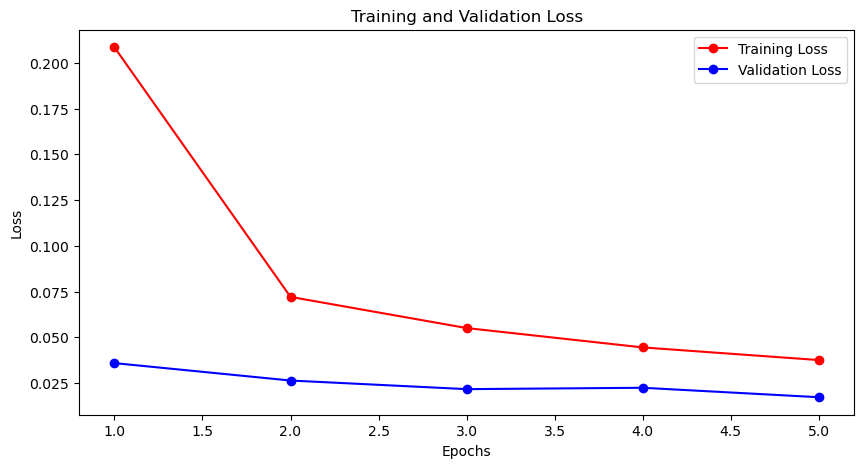

In [12]:
def plot_training_progress(train_losses, val_losses):
    epochs = range(1, len(train_losses) + 1)
    plt.figure(figsize=(10, 5))
    plt.plot(epochs, train_losses, 'ro-', label='Training Loss')
    plt.plot(epochs, val_losses, 'bo-', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

plot_training_progress(train_losses, val_losses)

### f) Évaluation du modèle

Pour évaluer le modèle, vous utiliserez le modèle entraîné pour faire des prédictions sur le jeu de données de test, puis vous comparerez ces prédictions aux étiquettes réelles pour calculer diverses mesures de performance. Nous utiliserons également une matrice de confusion pour visualiser la performance du modèle à travers différentes classes.

In [13]:
#Evaluate the model
def evaluate_model(model, test_loader):
    model.eval()  #Set the model to evaluation mode, which disables dropout and batch normalization
    model.to(device)
    val_loss = 0  #Initialize validation loss
    correct = 0  #Count of correct predictions
    total = 0  #Total number of examples processed
    all_preds = []  #List to store all predictions
    all_labels = []  #List to store all true labels

    with torch.no_grad():  #Disable gradient computation to speed up the process and reduce memory usage
        for images, labels in test_loader:  #Iterate over all batches in the test dataset
            images, labels = images.to(device), labels.to(device)  #Move images and labels to the specified device
            outputs = model(images)  #Compute the model's output
            loss = criterion(outputs, labels)  #Calculate the loss based on the criterion
            val_loss += loss.item()  #Accumulate the loss

            _, predicted = torch.max(outputs.data, 1)  #Get the predicted classes (highest output values)
            total += labels.size(0)  #Update total count of examples
            correct += (predicted == labels).sum().item()  #Update correct count based on how many predictions match the labels

            all_preds.extend(predicted.cpu().numpy())  #Store predictions in a list
            all_labels.extend(labels.cpu().numpy())  #Store true labels in a list

    avg_val_loss = val_loss / len(test_loader)  #Calculate average validation loss
    avg_accuracy = correct / total  #Calculate accuracy as the ratio of correct predictions to total examples

    return avg_val_loss, avg_accuracy, all_preds, all_labels  #Return the computed metrics and lists of predictions and labels


#Import model
model = resnet18(pretrained=False) 
#Adapt it to the number of classes on the last layer
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 10) 
#Load the model saved
state_dict = torch.load('model.pth')
model.load_state_dict(state_dict)

test_loss, test_accuracy, all_preds, all_labels = evaluate_model(model, test_loader)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%, Test Loss: {test_loss:.4f}")

Test Accuracy: 99.39%, Test Loss: 0.0172


Confusion matrix, without normalization


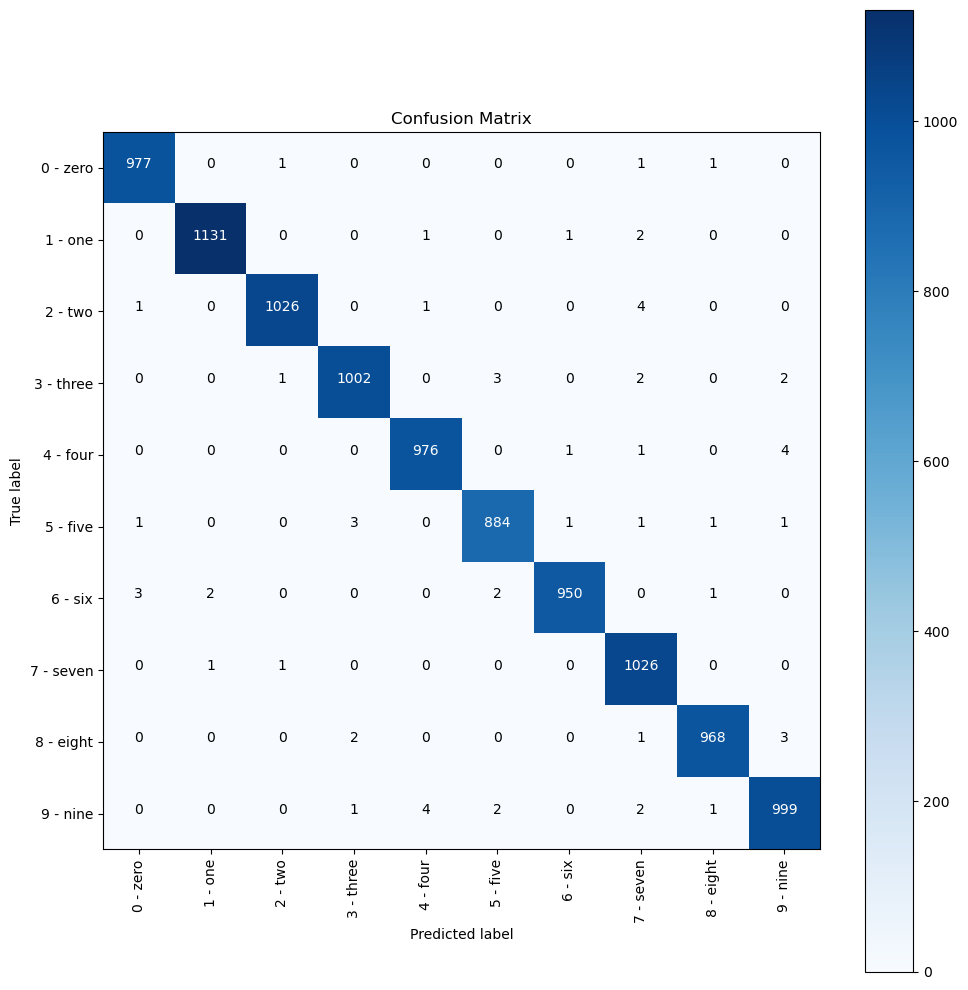

In [14]:
#Function to plot the confusion matrix
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    #If normalization is set to True, normalize the confusion matrix
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    #Print a message indicating whether the confusion matrix is normalized or not
    print("Confusion matrix, without normalization" if not normalize else "Normalized confusion matrix")

    #Create a new figure with a specified size
    plt.figure(figsize=(10, 10))
    #Display the confusion matrix as an image
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    #Set the title of the plot
    plt.title(title)
    #Add a color bar to the side of the plot
    plt.colorbar()
    #Set tick marks at each class index
    tick_marks = np.arange(len(classes))
    #Label the x-axis ticks with the class names, rotated 90 degrees
    plt.xticks(tick_marks, classes, rotation=90)
    #Label the y-axis ticks with the class names
    plt.yticks(tick_marks, classes)

    #Format the values in the confusion matrix as float with 2 decimals if normalized, otherwise as integers
    fmt = '.2f' if normalize else 'd'
    #Determine a threshold to change text color for better readability
    thresh = cm.max() / 2.
    #Iterate through each cell in the confusion matrix
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        #Place the text in the middle of each cell
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    #Adjust the layout for better fit
    plt.tight_layout()
    #Label the y-axis as 'True label'
    plt.ylabel('True label')
    #Label the x-axis as 'Predicted label'
    plt.xlabel('Predicted label')

#Calculate and plot the confusion matrix
#`all_labels` contains the true labels and `all_preds` contains the predicted labels
cm = confusion_matrix(all_labels, all_preds)
#`classes` contains the list of class names
plot_confusion_matrix(cm, classes, normalize=False, title='Confusion Matrix')

### g) Faire des prédictions avec le modèle enregistré

Faites des prédictions sur des images d'exemple issues de l'ensemble de test.

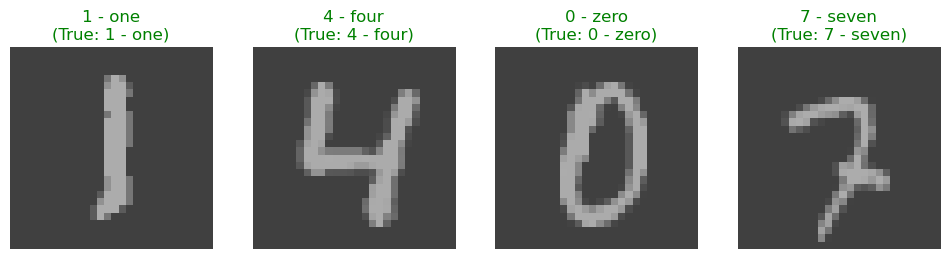

In [15]:
def predict_and_display(model, data_loader, class_names, device='cuda', num_images=4):
    model.eval()  #Set the model to evaluation mode
    model.to(device)
    
    with torch.no_grad():  #Turn off gradients to speed up this part
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predictions = torch.max(outputs, 1)
            
            #Select a random subset of images
            indices = np.random.choice(len(images), num_images, replace=False)

            #Normalize mean and std used for your data
            mean = np.array([0.1307, 0.1307, 0.1307])
            std = np.array([0.3081, 0.3081, 0.3081])
            
            #Plot the images in the batch, along with predicted and true labels
            fig, axes = plt.subplots(1, num_images, figsize=(12, 3))
            for idx, img_idx in enumerate(indices):
                image = images[img_idx].cpu().numpy().transpose((1, 2, 0))
                image = (image * mean) + std  #Unnormalize if necessary
                ax = axes[idx]
                ax.imshow(image, cmap='gray')
                ax.set_title(f"{class_names[predictions[img_idx]]}\n(True: {class_names[labels[img_idx]]})", 
                             color=("green" if predictions[img_idx] == labels[img_idx] else "red"))
                ax.axis('off')
            plt.show()
            
            #Break after displaying the first batch's selected images
            break


predict_and_display(model, test_loader, classes, device)